In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pycytominer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. Load data

In [2]:
df = pd.read_csv('D:/Downloads/well_profiles.csv')

# 2. Calculate PCA and t-SNE for raw data (embedding features)

In [7]:
# Extract embedding data
embedding_data = df[[col for col in df.columns if col.startswith('emb_')]].values

# Initialize and fit PCA
pca_model = PCA(n_components=50)
pca_embedding = pca_model.fit_transform(embedding_data)

# Add PCA result to the DataFrame
df['pca_embedding_x'] = pca_embedding[:, 0]
df['pca_embedding_y'] = pca_embedding[:, 1]

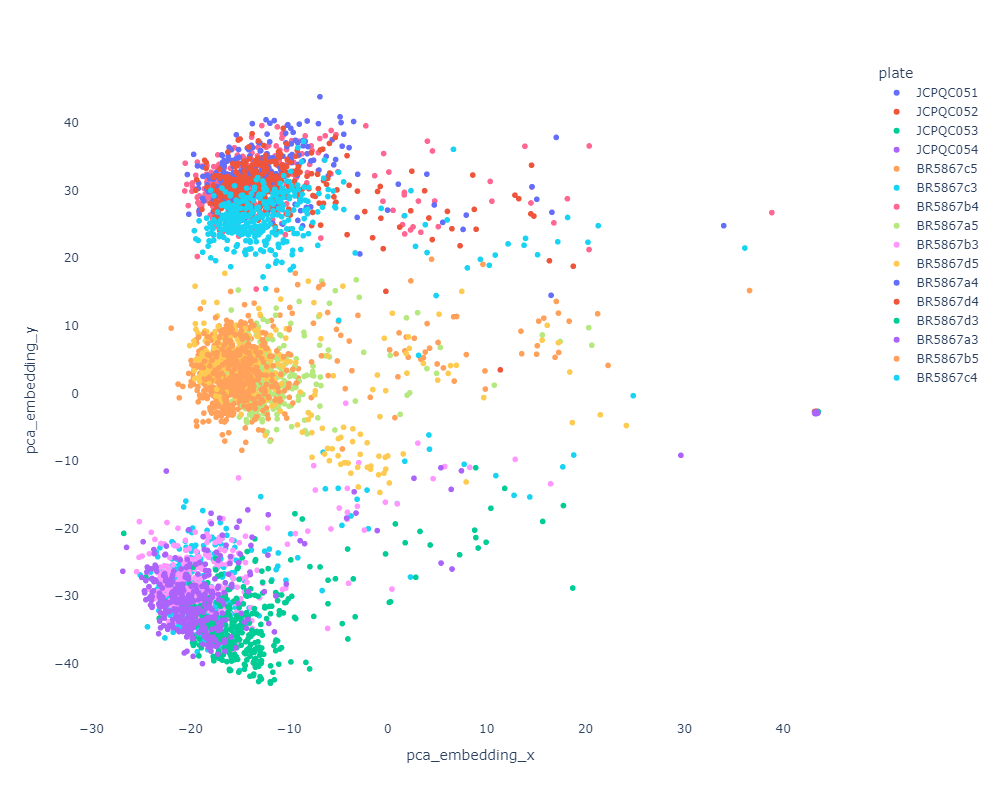

In [47]:
fig = px.scatter(
    df, 
    x='pca_embedding_x', 
    y='pca_embedding_y', 
    color='plate', 
    height=800
)
fig.update_layout(
    plot_bgcolor='white', paper_bgcolor='white'
)
fig.show()

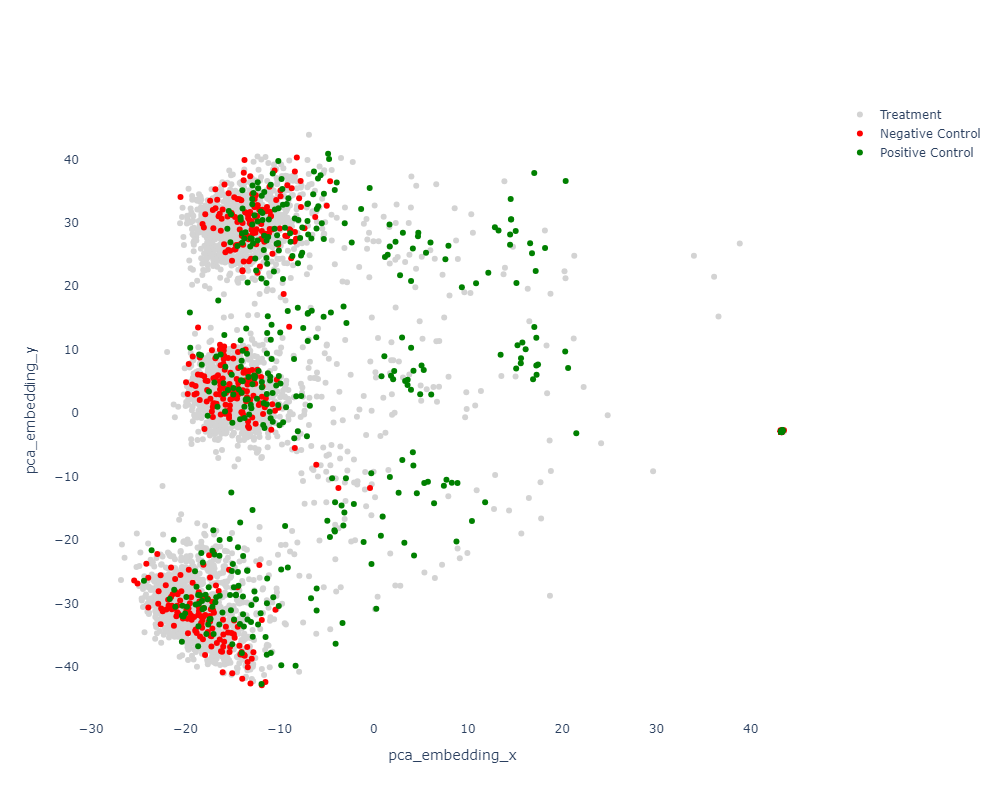

In [51]:
def plot_controls(df, x_col, y_col):
    # First, create subsets of data based on 'control_type'
    null_control_df = df[df['control_type'].isnull()]
    poscon_df = df[df['control_type'] == 'poscon']
    negcontrol_df = df[df['control_type'] == 'negcon']

    # Create the figure
    fig = go.Figure()

    # Add the scatter plot for null control (gray)
    fig.add_trace(go.Scatter(
        x=null_control_df[x_col], y=null_control_df[y_col],
        mode='markers',
        marker=dict(color='lightgray'),
        name='Treatment'
    ))

    # Add the scatter plot for negcontrol (red)
    fig.add_trace(go.Scatter(
        x=negcontrol_df[x_col], y=negcontrol_df[y_col],
        mode='markers',
        marker=dict(color='red'),
        name='Negative Control'
    ))

    # Add the scatter plot for poscon (green)
    fig.add_trace(go.Scatter(
        x=poscon_df[x_col], y=poscon_df[y_col],
        mode='markers',
        marker=dict(color='green'),
        name='Positive Control'
    ))

    fig.update_layout(
        xaxis_title=x_col, yaxis_title=y_col,
        height=800,
        plot_bgcolor='white', paper_bgcolor='white'
    )

    # Show the plot
    fig.show()

plot_controls(df, 'pca_embedding_x', 'pca_embedding_y')

In [38]:
# Extract embedding data
embedding_data = df[[col for col in df.columns if col.startswith('emb_')]].values

# Initialize and fit t-SNE (with 2 components for 2D visualization)
tsne_model = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne_model.fit_transform(embedding_data)

# Add t-SNE result to the DataFrame (optional, for reference)
df['tsne_embedding_x'] = tsne_embedding[:, 0]
df['tsne_embedding_y'] = tsne_embedding[:, 1]

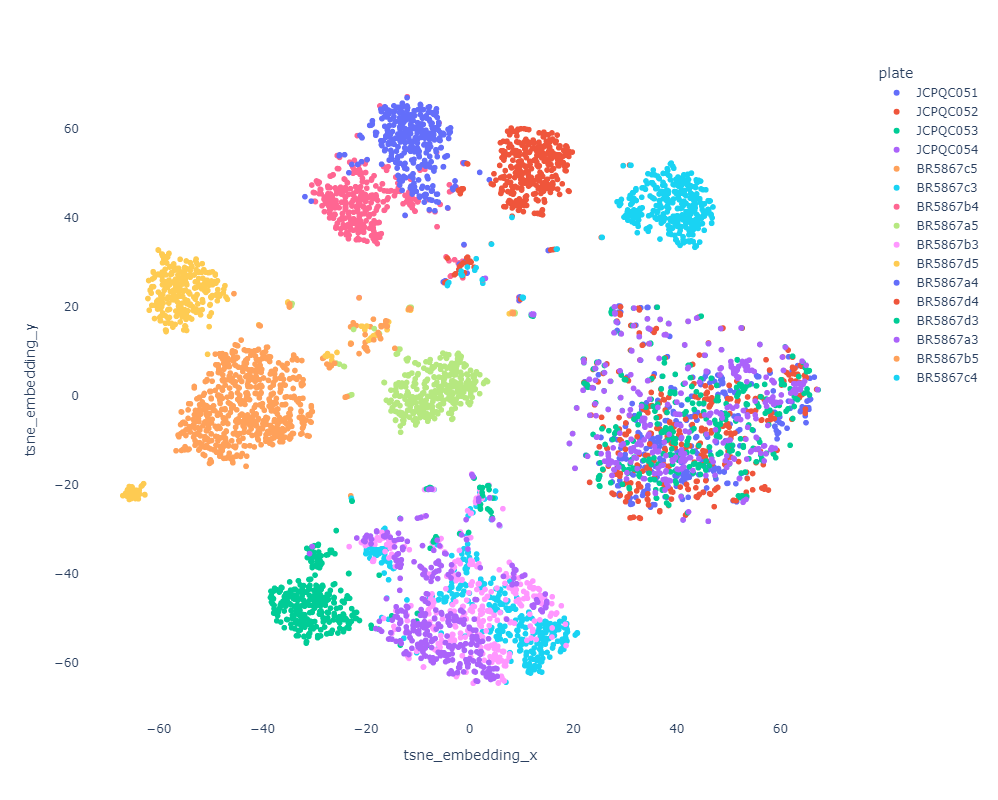

In [48]:
fig = px.scatter(
    df, 
    x='tsne_embedding_x', 
    y='tsne_embedding_y',  
    color='plate', 
    height=800
)
fig.update_layout(
    plot_bgcolor='white', paper_bgcolor='white'
)
fig.show()

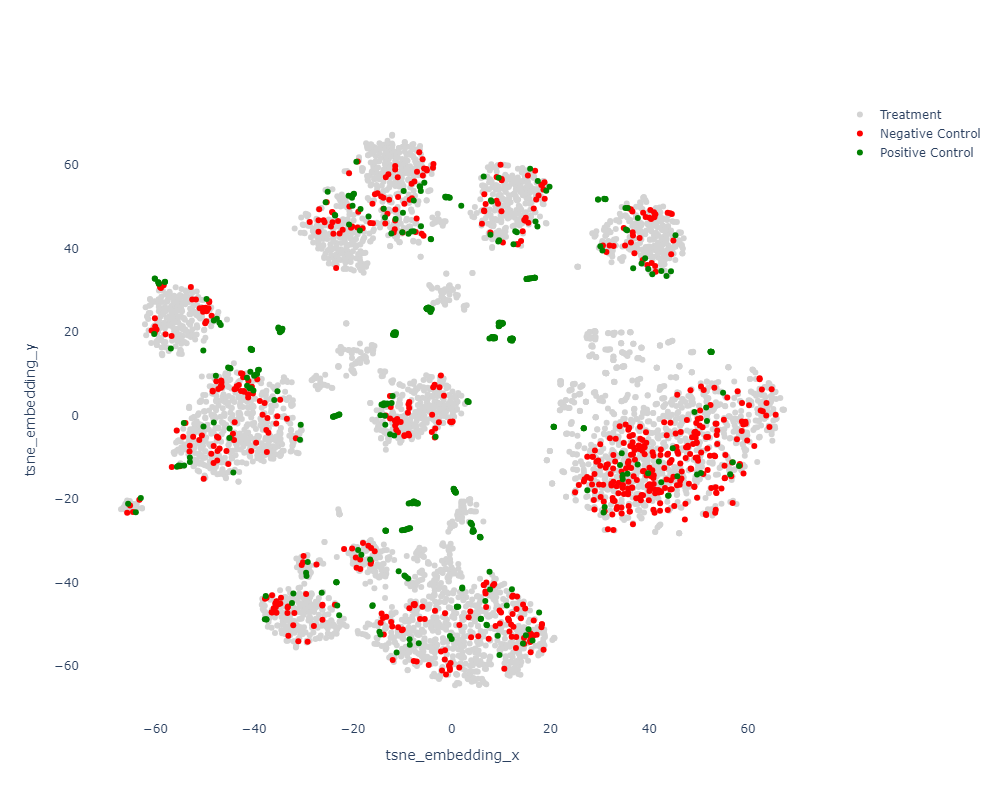

In [46]:
plot_controls(df, 'tsne_embedding_x', 'tsne_embedding_y')

# 3. Normalize data with pycytominer

In [52]:
normalized_dfs = []

# Group by plate and normalize each plate separately
for plate, plate_df in df.groupby('plate'):
    normalized_plate_df = pycytominer.normalize(
        profiles = plate_df,
        features = [col for col in df.columns if col.startswith('emb_')],
        meta_features = ['plate', 'well', 'concentration', 'condition_name', 'control_type', 
                 'perturbation_type', 'plate_type'],
        samples = "perturbation_type == 'control'"#,
        #samples = "condition_name == 'DMSO-0.0'",
        #method = "mad_robustize"
    )
    normalized_dfs.append(normalized_plate_df)

normalized_df = pd.concat(normalized_dfs, ignore_index=True)

In [54]:
# Extract embedding data
embedding_data = normalized_df[[col for col in normalized_df.columns if col.startswith('emb_')]].values

# Initialize and fit t-SNE (with 2 components for 2D visualization)
tsne_model = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne_model.fit_transform(embedding_data)

# Add t-SNE result to the DataFrame (optional, for reference)
normalized_df['tsne_embedding_x'] = tsne_embedding[:, 0]
normalized_df['tsne_embedding_y'] = tsne_embedding[:, 1]

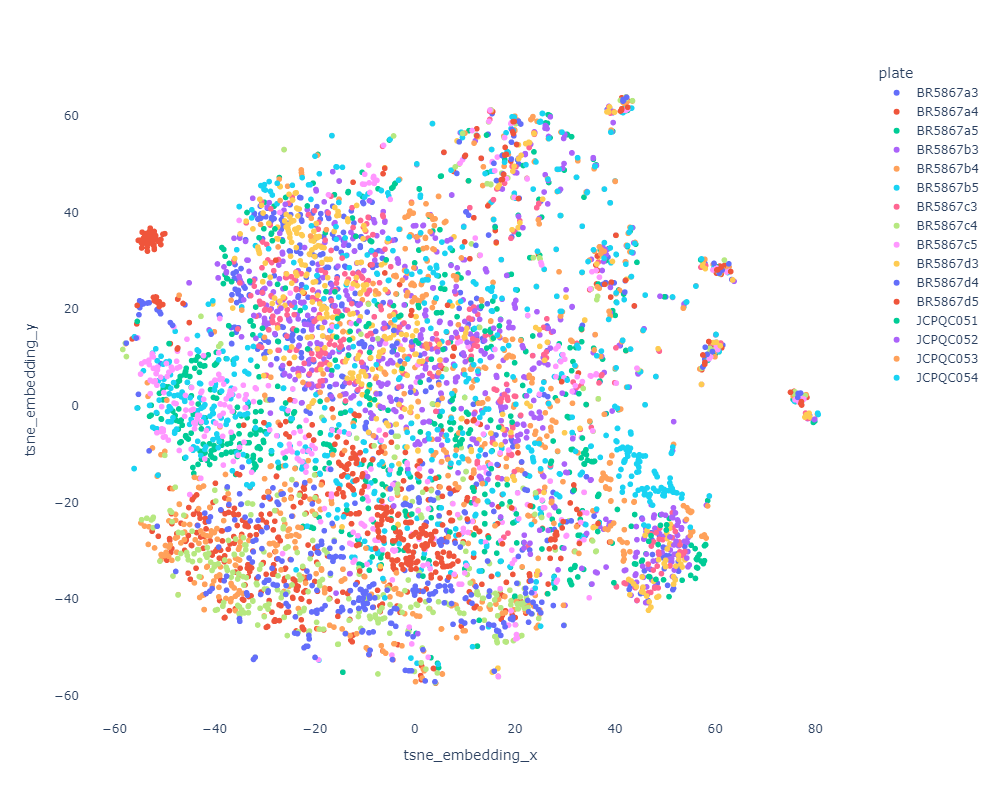

In [55]:
fig = px.scatter(
    normalized_df, 
    x='tsne_embedding_x', 
    y='tsne_embedding_y',  
    color='plate', 
    height=800
)
fig.update_layout(
    plot_bgcolor='white', paper_bgcolor='white'
)
fig.show()

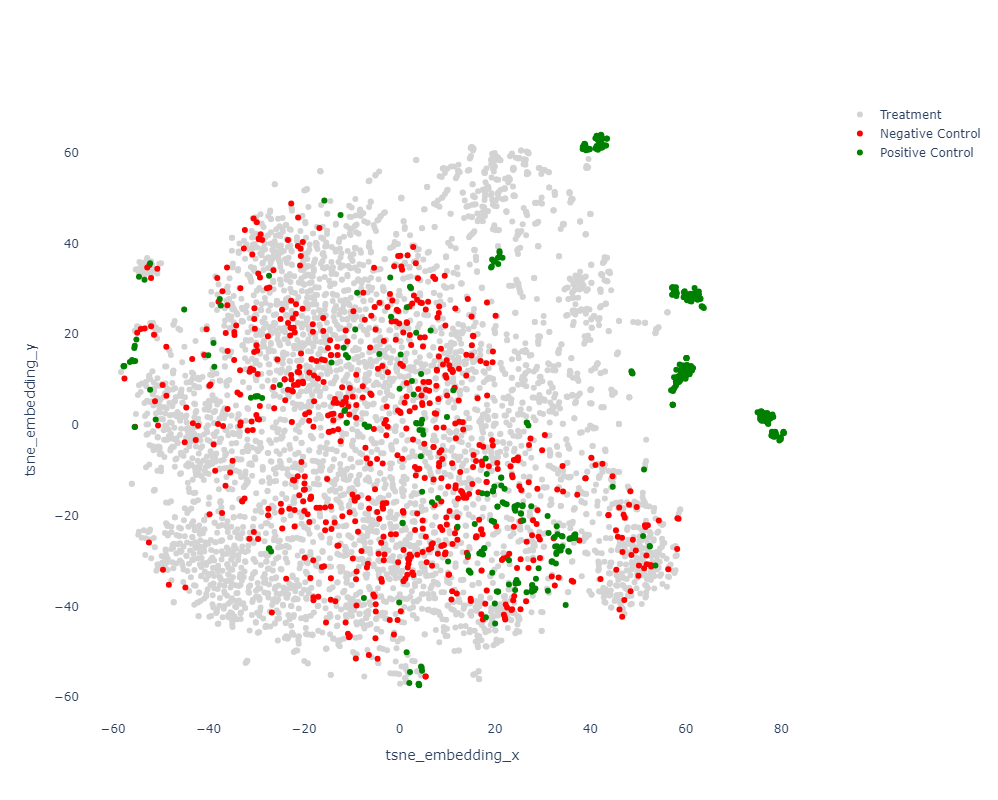

In [56]:
plot_controls(normalized_df, 'tsne_embedding_x', 'tsne_embedding_y')

# An old visualisation I showed to you on Saturday evening

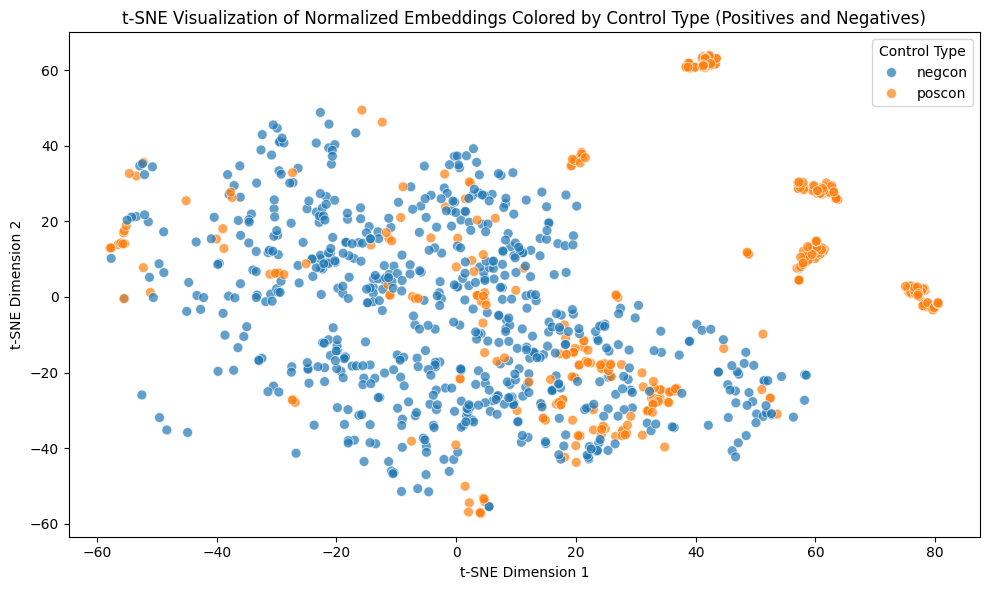

In [57]:
# Plot the t-SNE results for the normalized data, colored by 'control_type' (positives and negatives)
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to color by 'control_type', assuming the column exists in the DataFrame
sns.scatterplot(x='tsne_embedding_x', y='tsne_embedding_y', hue='control_type', data=normalized_df, s=50, alpha=0.7)

plt.title('t-SNE Visualization of Normalized Embeddings Colored by Control Type (Positives and Negatives)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Control Type', loc='best')
plt.tight_layout()
plt.show()

# Some unused visualisations

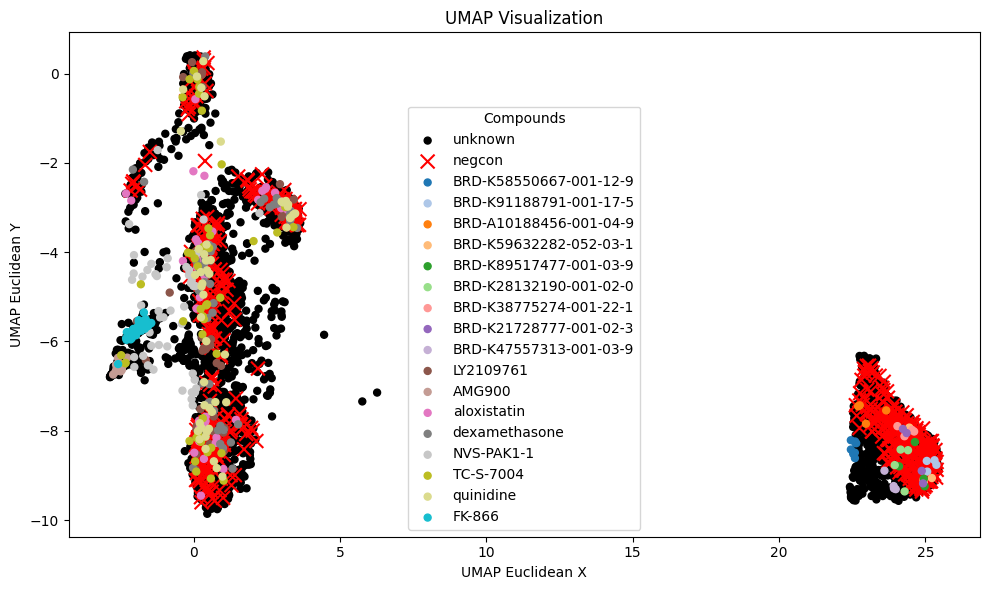

In [21]:
# Correcting the use of colormaps.get_cmap with the correct number of arguments
import matplotlib.pyplot as plt

# Use the correct colormap retrieval method for Matplotlib 3.7+
color_palette = plt.colormaps['tab20']  # No need to pass a length, use the colormap object directly

# Create a color map for perturbation_id for 'poscon'
perturbation_color_map = {pert: color_palette(i / len(unique_perturbations)) for i, pert in enumerate(unique_perturbations)}

# Set colors based on control_type and perturbation_id
df['color'] = df.apply(lambda x: 'black' if x['legend_label'] == 'unknown' else
                                  'red' if x['legend_label'] == 'negcon' else
                                  perturbation_color_map.get(x['perturbation_id'], 'black'), axis=1)

# Set markers based on control type
df['marker'] = df.apply(lambda x: 'x' if x['legend_label'] == 'negcon' else
                                  '.' if x['legend_label'] != 'unknown' else
                                  '.', axis=1)

# Plot the UMAP visualization
plt.figure(figsize=(10, 6))

# Loop through the unique legend labels and plot each group separately to handle markers and colors
for label in df['legend_label'].unique():
    subset = df[df['legend_label'] == label]
    plt.scatter(subset['umap_euclidean_x'], subset['umap_euclidean_y'],
                color=subset['color'].values, label=label, marker=subset['marker'].values[0], s=100)

plt.title('UMAP Visualization')
plt.xlabel('UMAP Euclidean X')
plt.ylabel('UMAP Euclidean Y')
plt.legend(title='Compounds', loc='best')
plt.tight_layout()
plt.show()


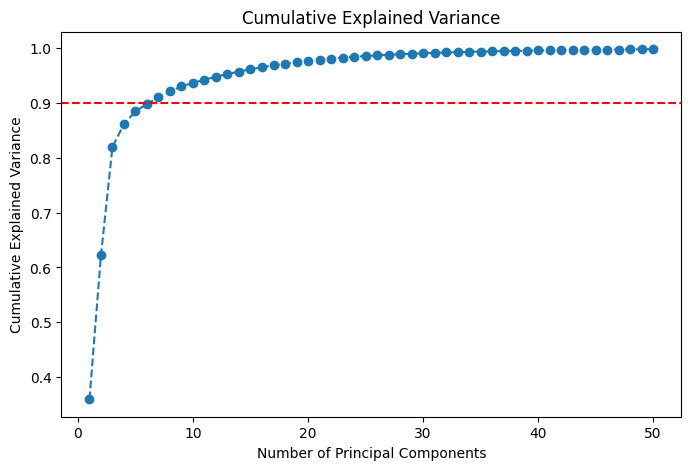

In [50]:
# After fitting the PCA model
explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--')  # Horizontal line at 90% explained variance
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()